In [1]:
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt

def show_img(image):
    plt.figure(figsize=(16,16))
    if(len(image.shape) == 2):
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)

In [24]:
train = cv2.imread("../vision/template.jpg")
train_gray = cv2.cvtColor(train, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kpTrain, desTrain = sift.detectAndCompute(train_gray, None)

In [25]:
def test(test_gray):
    kpTest, desTest = sift.detectAndCompute(test_gray, None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(desTrain, desTest,k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    MIN_MATCH_COUNT = 10
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kpTrain[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kpTest[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w = train_gray.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

        dst = cv2.perspectiveTransform(pts,M)

        ret = np.int32(dst)[:,0,:]

        # at least 0
        ret[ret < 0] = 0
        th,tw = test_gray.shape
        
        # not to exceed width
        mask = np.zeros_like(ret)
        mask[:,0] = 1
        ret[(ret > tw) & (mask == 1)] = tw

        # not to exceed height
        mask = np.zeros_like(ret)
        mask[:,1] = 1
        ret[(ret > th) & (mask == 1)] = th

        return ret

    else:
        print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        matchesMask = None
        return None

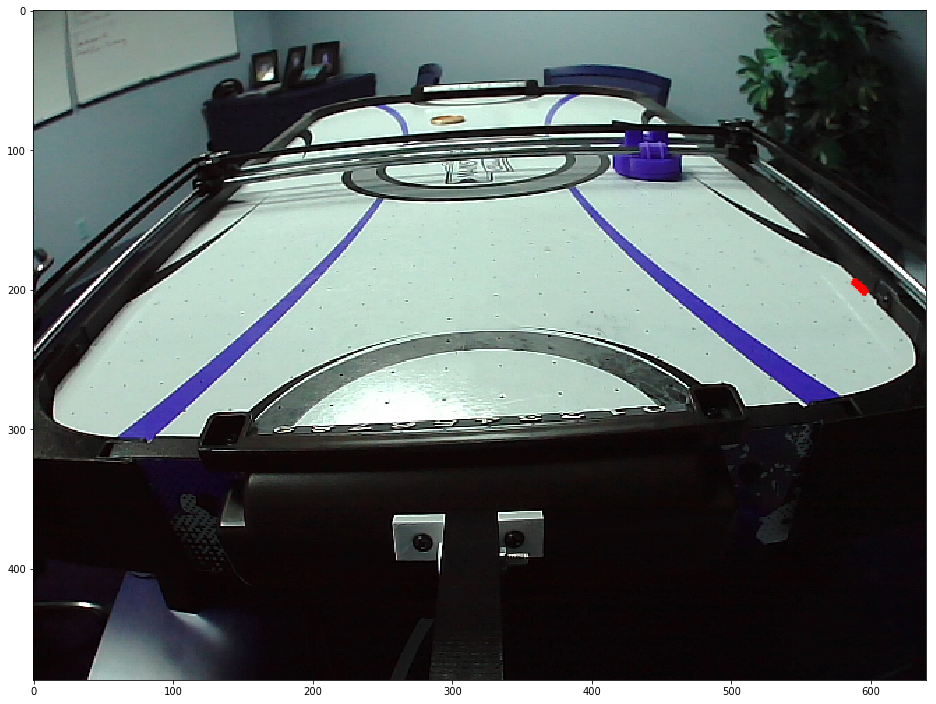

In [26]:
test_img = cv2.imread("./images/raw_screenshot_08.08.2018.png")
test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
rect = test(test_img_gray)
test_lined = cv2.polylines(test_img.copy(),[rect],True,255,3, cv2.LINE_AA)
show_img(test_lined)

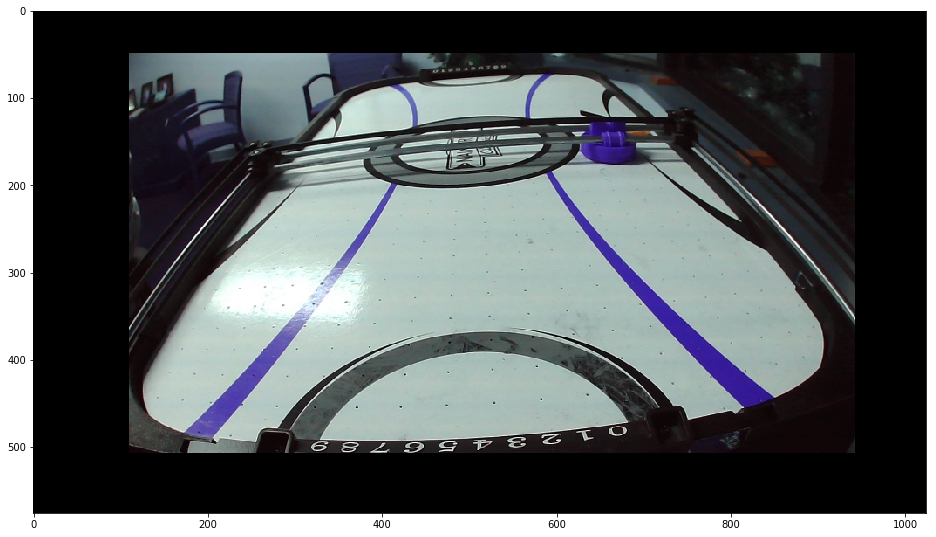

In [6]:
just_rect = np.zeros_like(test_img)
just_rect[min(rect[:,1]):max(rect[:,1]), min(rect[:,0]):max(rect[:,0])] = test_img[min(rect[:,1]):max(rect[:,1]), min(rect[:,0]):max(rect[:,0])]
show_img(just_rect)

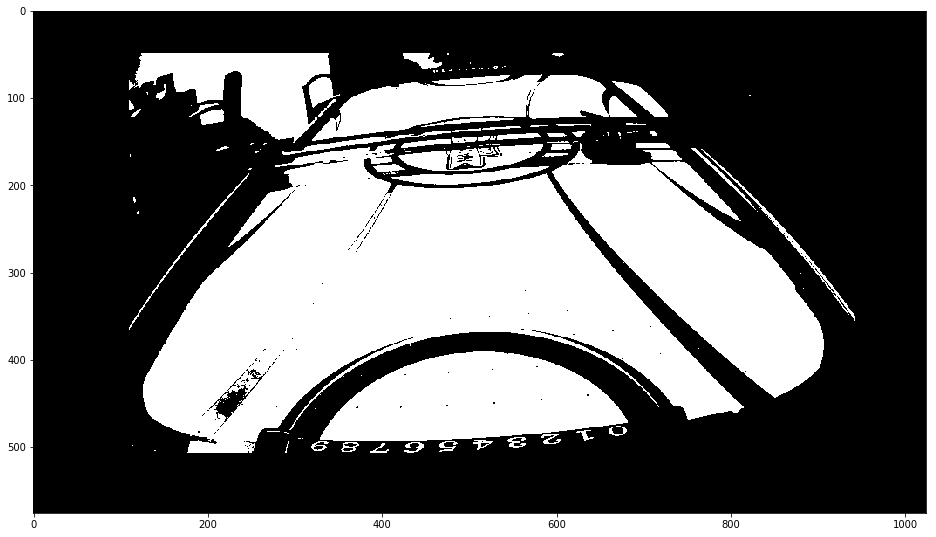

In [8]:
just_gray = cv2.cvtColor(just_rect, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(just_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
show_img(thresh)

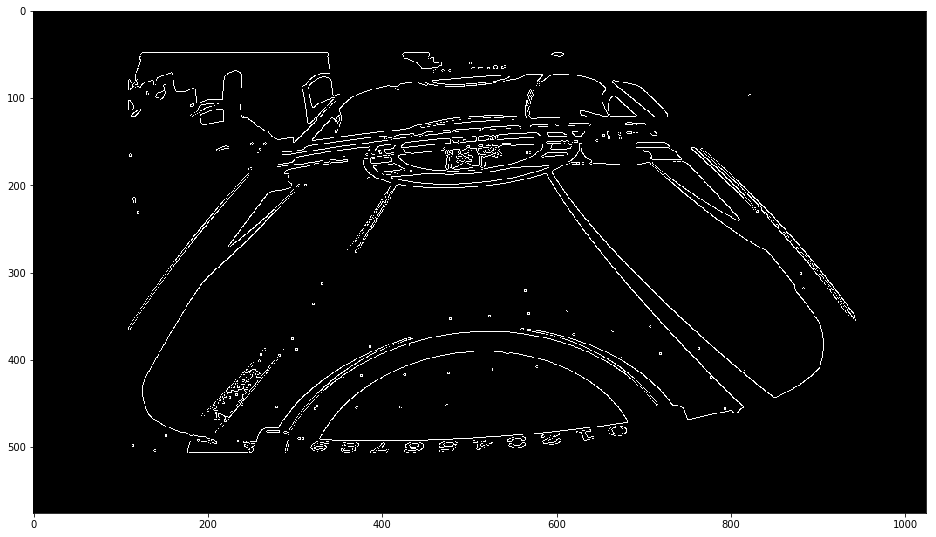

In [9]:
edges = cv2.Canny(thresh, 1, 1)
show_img(edges)

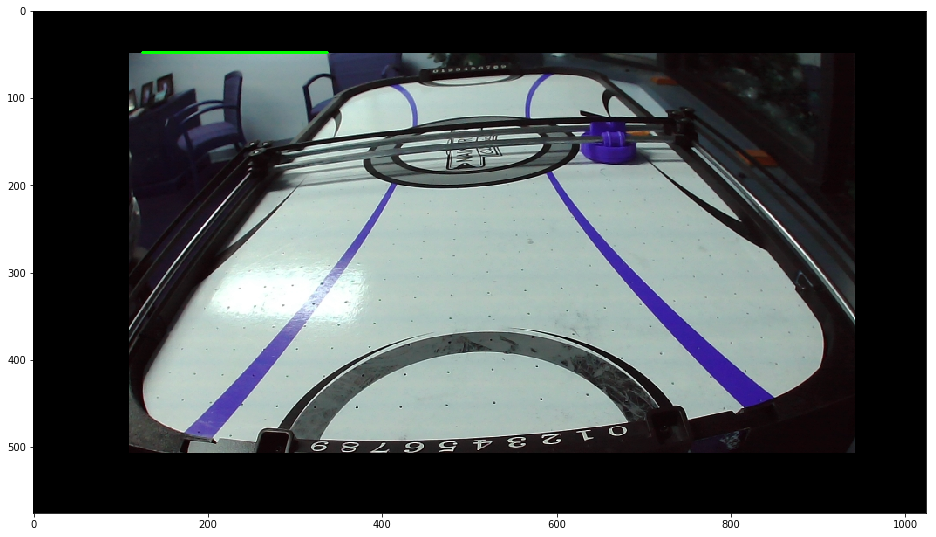

In [49]:
disp = just_rect.copy()

lines = cv2.HoughLinesP(edges,1,np.pi/32,100)

for x1,y1,x2,y2 in lines[0]:
    cv2.line(disp,(x1,y1),(x2,y2),(0,255,0),2)

show_img(disp)

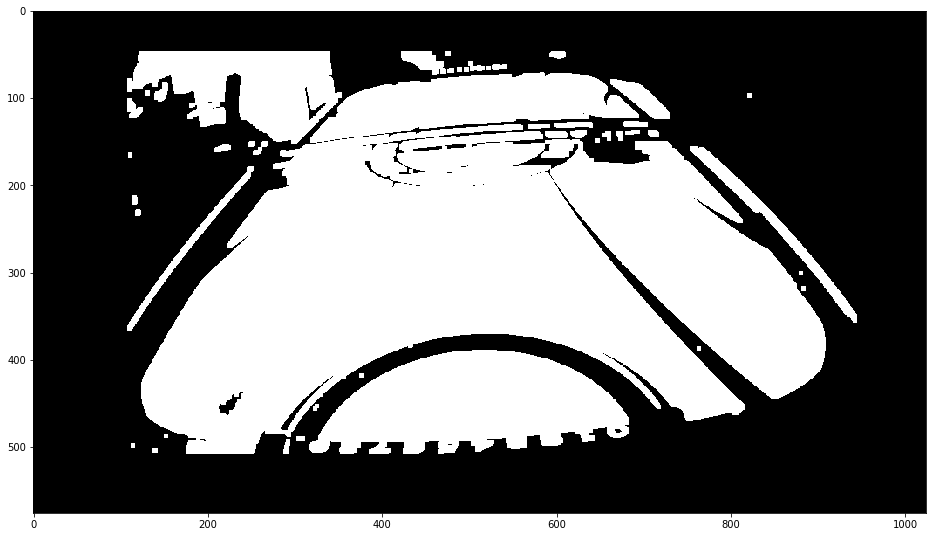

In [10]:
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(thresh, kernel, iterations = 1)
show_img(dilation)

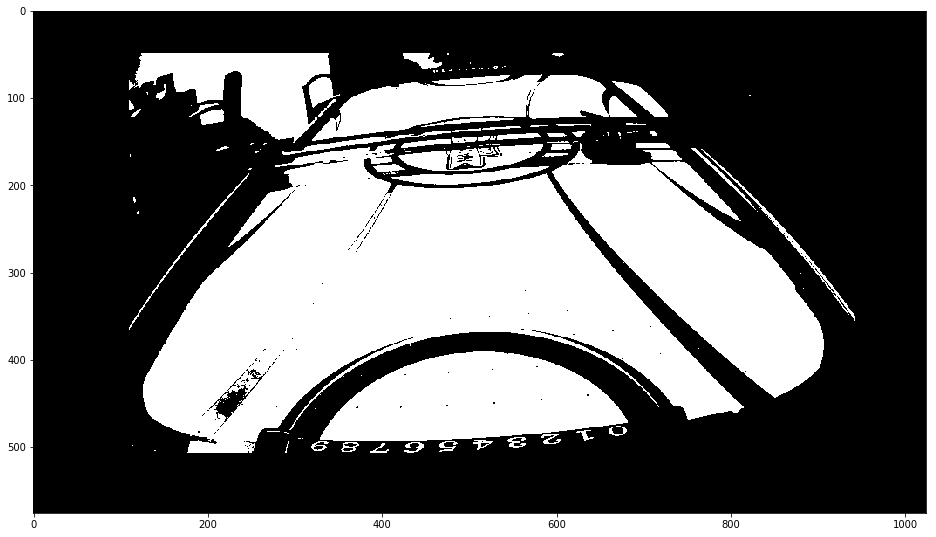

In [13]:
from skimage import segmentation, filters, img_as_ubyte

mask = just_gray > filters.threshold_otsu(just_gray)
clean_border = segmentation.clear_border(mask)
show_img(clean_border)

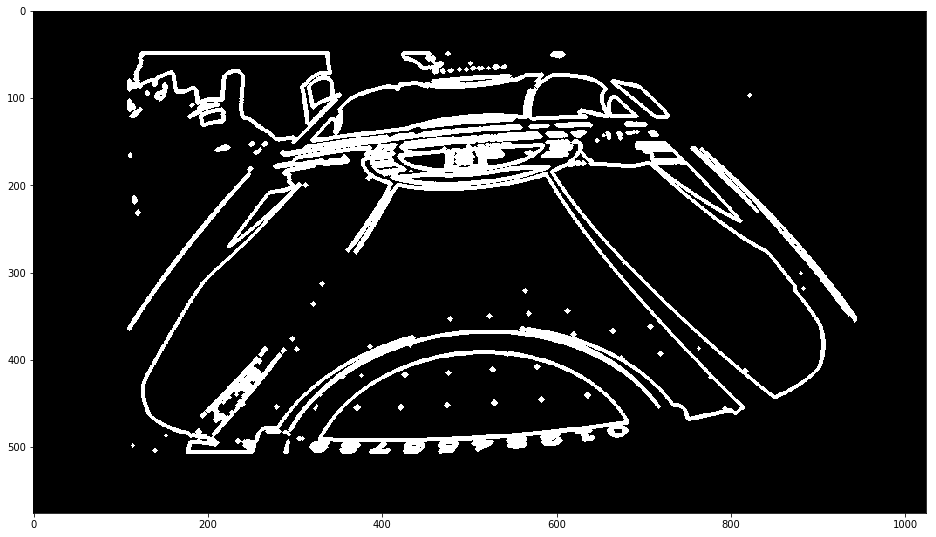

In [14]:
cv_image = img_as_ubyte(clean_border)
no_lava = np.zeros_like(cv_image)
im2, contours, hierarchy = cv2.findContours(cv_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
c = max(contours, key = cv2.contourArea)
cv2.drawContours(no_lava, contours, -1, (255,255,255), 3)
show_img(no_lava)

In [69]:
def remove_noise(image):
    wk_img=image.copy()
    
    # Baseline params
    kernel1=5
    kernel2=60
    while True:    
        kernel = np.ones((kernel1,kernel2))
        opened=cv2.morphologyEx(wk_img,cv2.MORPH_OPEN, kernel)    
        zero_count_l=np.count_nonzero(opened[:,:120])
        zero_count_r=np.count_nonzero(opened[:,1780:])
        if zero_count_l > 0 or zero_count_r > 0:
            kernel2+=1
        else:
            break

    closed=cv2.morphologyEx(opened, cv2.MORPH_CLOSE, np.ones((10,10)))
    return closed.copy()

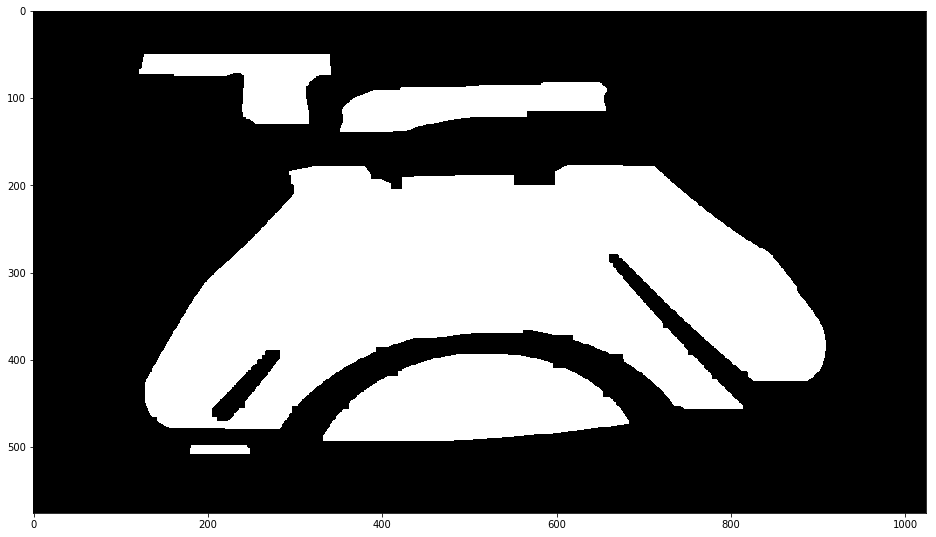

In [16]:
clean_img = remove_noise(cv_image)
show_img(clean_img)

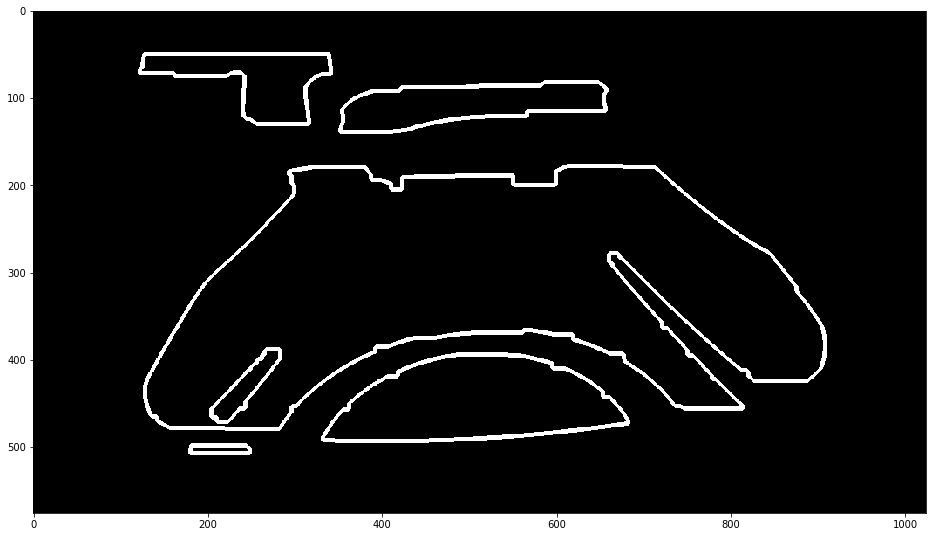

In [50]:
no_lava = np.zeros_like(clean_img)
im2, contours, hierarchy = cv2.findContours(clean_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(no_lava, contours, -1, (255,255,255), 3)
show_img(no_lava)

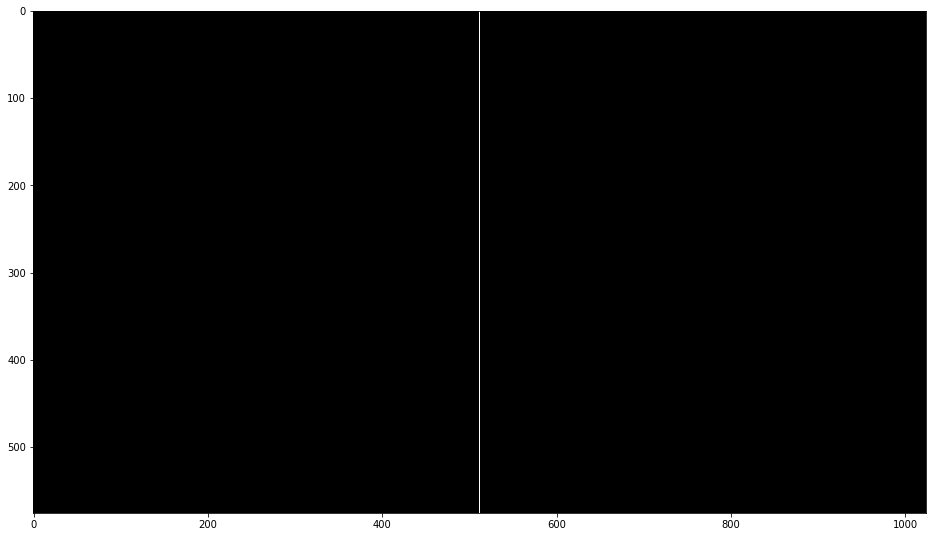

In [141]:
line = np.zeros_like(no_lava)
mid = int(no_lava.shape[1]/2)
line[:, mid:mid+1] = 1
show_img(line)

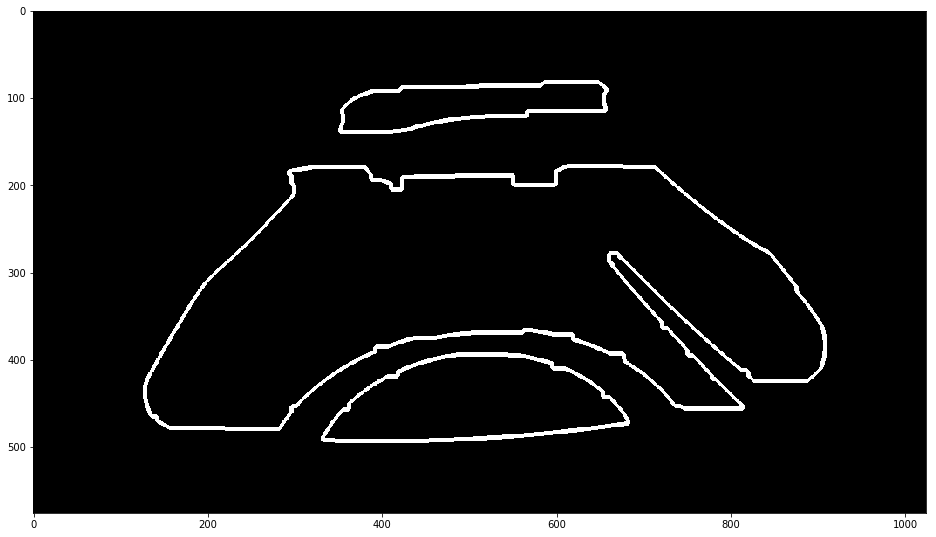

In [125]:
touches_line = []
for contour in contours:
    touches = np.zeros_like(no_lava)
    cv2.drawContours(touches, [contour], -1, (255,255,255), 3)
    if np.any(touches & line):
        touches_line.append(contour)

liners = np.zeros_like(no_lava)
cv2.drawContours(liners, touches_line, -1, (255,255,255), 3)
show_img(liners)

[[[  31.90789  523.79346]]

 [[1032.4481   463.15466]]

 [[ 489.72318  -84.61894]]]


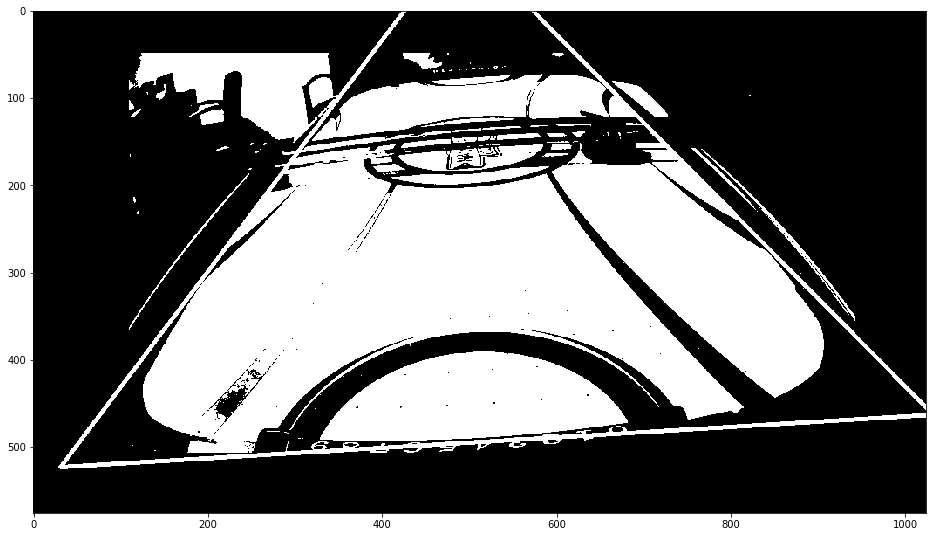

In [137]:
a, triangle = cv2.minEnclosingTriangle(np.array([np.argwhere(liners.T)]))
tri = np.zeros_like(no_lava)
tri = cv2.polylines(cv_image, np.int32([triangle]), True, (255, 255, 255), 3)
print(triangle)
show_img(tri)


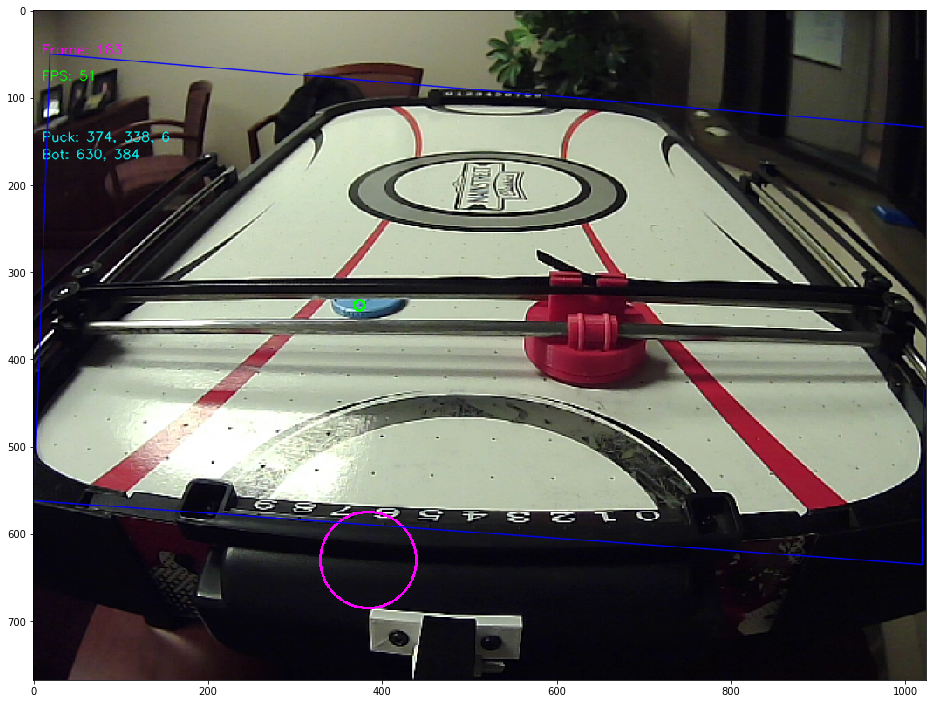

In [5]:
puck_img = cv2.imread("./images/Preview_screenshot_08.08.2018.png")
rgb = cv2.cvtColor(puck_img, cv2.COLOR_BGR2RGB)
show_img(rgb)

In [61]:
def find_bot(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[0:200,:,:] = 0 
    lowerBound = np.array([120,150,100])
    upperBound = np.array([130,255,150])

    mask = cv2.inRange(hsv, lowerBound, upperBound)
    el = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed = cv2.dilate(mask, el, iterations=3)

    _, contours,hierarchy = cv2.findContours(closed, 2, 1)
    contour_list = []
    for contour in contours:
        approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
        area = cv2.contourArea(contour)
        if ((len(approx) > 8) & (area > 30) ):
            contour_list.append(contour)
    if not contour_list:
        return (0, 0), 0
    c = max(contour_list, key = cv2.contourArea)
    center, radius = cv2.minEnclosingCircle(c)
    return tuple(np.int0(center)), int(radius)

(5, 434) 54


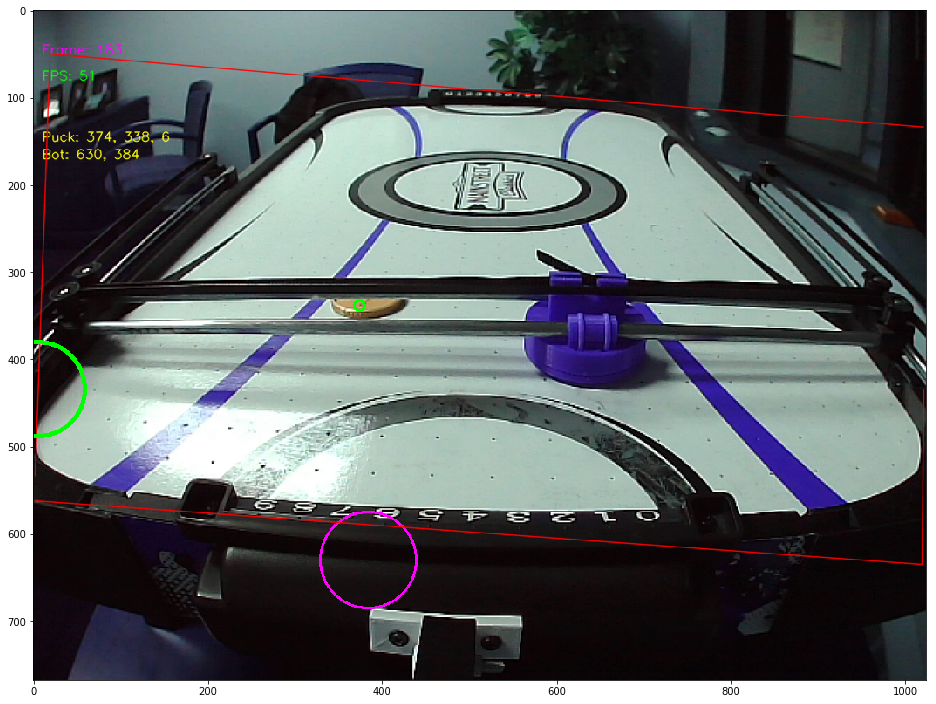

In [62]:
center, radius = find_bot(puck_img)
print(center, radius)
foo = cv2.circle(puck_img.copy(), tuple(np.asarray(center, dtype=np.int)), int(radius), (0,255,0), 4)
show_img(foo)

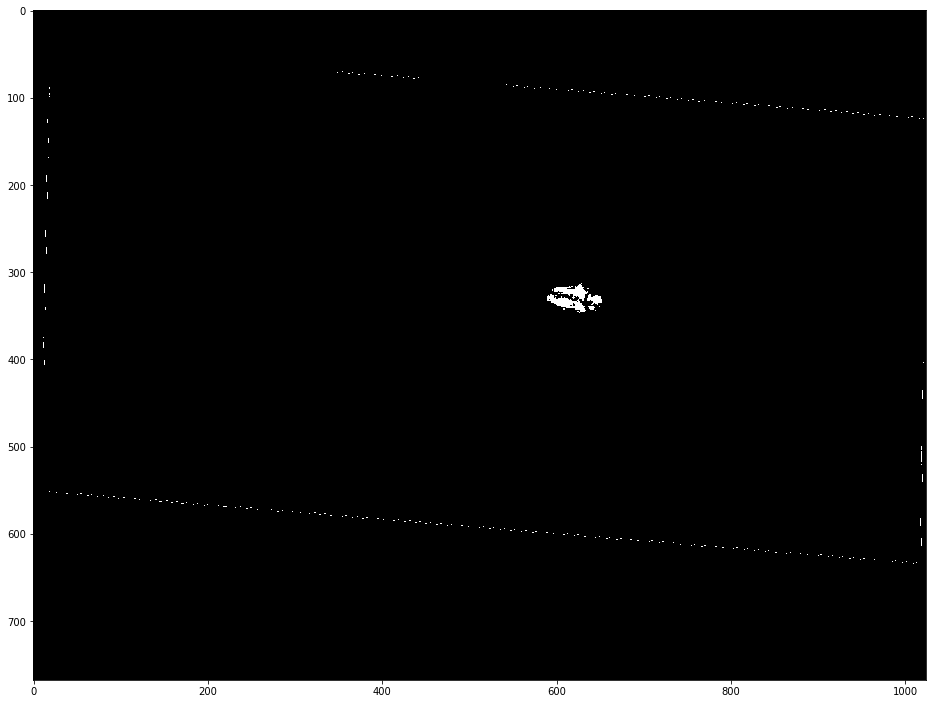

In [95]:
pucklowerBound = np.array([0,0,130])
puckupperBound = np.array([50,100,160])
mask=cv2.inRange(rgb,pucklowerBound,puckupperBound)
show_img(mask)

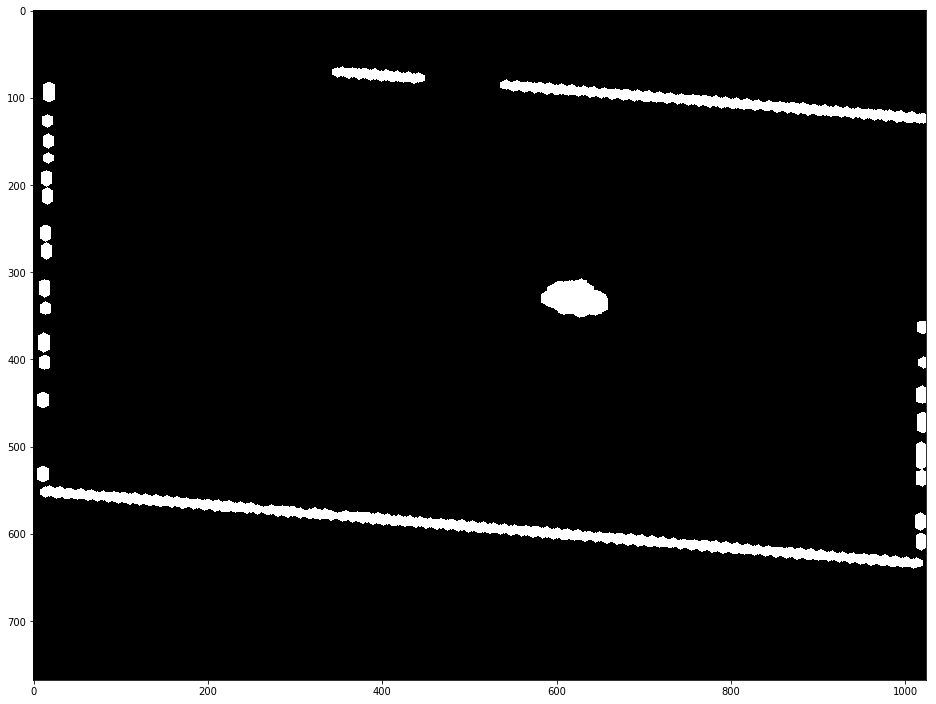

In [105]:
kernel = np.ones((5,5),np.uint8)

el = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
closed = cv2.dilate(mask, el, iterations=3)

show_img(closed)

(612.7919921875, 331.0719909667969) 23.98961067199707


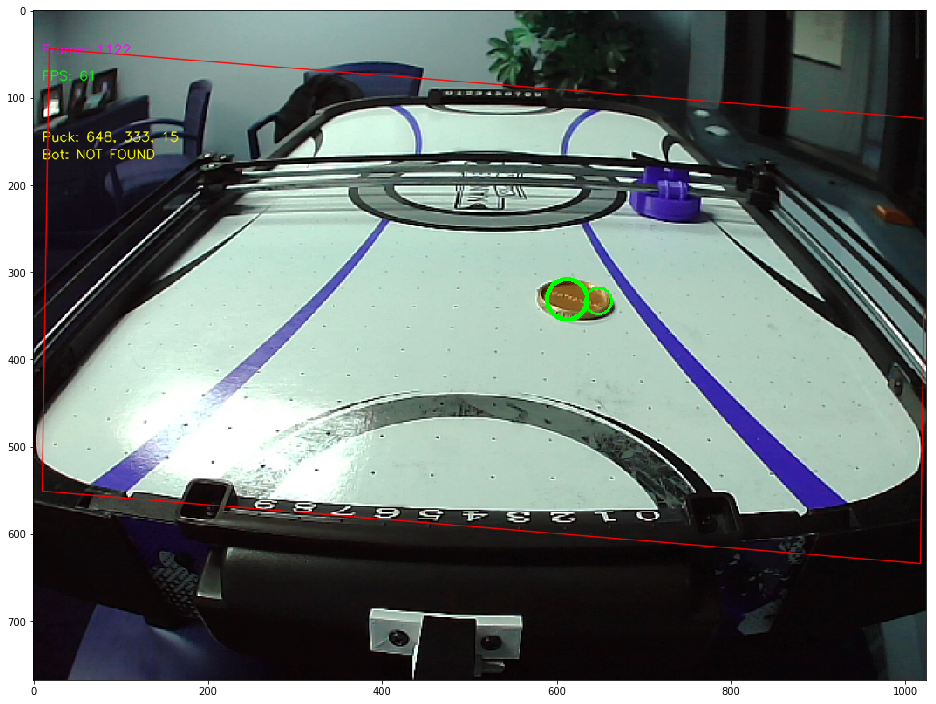

In [97]:
_, contours,hierarchy = cv2.findContours(mask, 2, 1)

contour_list = []
for contour in contours:
    approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    if ((len(approx) > 8) & (area > 30) ):
        contour_list.append(contour)
        
c = max(contour_list, key = cv2.contourArea)
puck_center, puck_radius = cv2.minEnclosingCircle(c)
print(puck_center, puck_radius)
disp = puck_img.copy()
cv2.circle(disp, tuple(np.asarray(puck_center, dtype=np.int)), int(puck_radius), (0,255,0), 4)
show_img(disp)

In [99]:
image = mask.copy()

el = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
image = cv2.dilate(image, el, iterations=6)

contours, hierarchy = cv2.findContours(
    image,
    cv2.RETR_LIST,
    cv2.CHAIN_APPROX_SIMPLE
)

centers = []
radii = []
for contour in contours:
    area = cv2.contourArea(contour)

    # there is one contour that contains all others, filter it out
    if area > 500:
        continue

    br = cv2.boundingRect(contour)
    radii.append(br[2])

    m = cv2.moments(contour)
    center = (int(m['m10'] / m['m00']), int(m['m01'] / m['m00']))
    centers.append(center)

print("There are {} circles".format(len(centers)))

radius = int(np.average(radii)) + 5

for center in centers:
    cv2.circle(image, center, 3, (255, 0, 0), -1)
    cv2.circle(image, center, radius, (0, 255, 0), 1)

show_img(image)

ValueError: too many values to unpack (expected 2)

[[[ 36.600002 168.6       23.920002]
  [612.60004  371.40002   42.16    ]]]


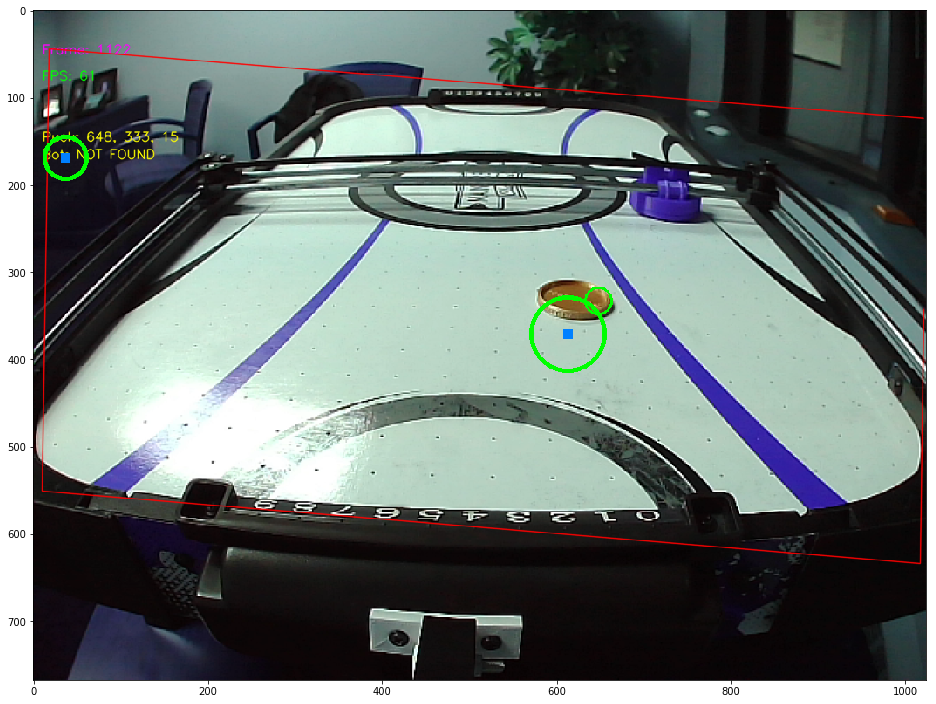

In [66]:
edges = cv2.Canny(mask, 150, 130)
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1.2, 100,
          param1=80,
          param2=30,
          minRadius=10,
          maxRadius=60)
print(circles)

output = puck_img.copy()

# ensure at least some circles were found
if circles is not None:
	# convert the (x, y) coordinates and radius of the circles to integers
	circles = np.round(circles[0, :]).astype("int")
 
	# loop over the (x, y) coordinates and radius of the circles
	for (x, y, r) in circles:
		# draw the circle in the output image, then draw a rectangle
		# corresponding to the center of the circle
		cv2.circle(output, (x, y), r, (0, 255, 0), 4)
		cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
        
show_img(output)

In [13]:
opened=cv2.morphologyEx(mask,cv2.MORPH_OPEN, np.ones((1,3)))
closed=cv2.morphologyEx(opened, cv2.MORPH_CLOSE, np.ones((20,20)))
pts = np.argwhere(closed)
puck_center, puck_radius = cv2.minEnclosingCircle(pts)
int_puck_center, int_puck_radius = np.asarray(puck_center, dtype=int), int(puck_radius)
int_puck_center, int_puck_radius

(array([500, 166]), 26)

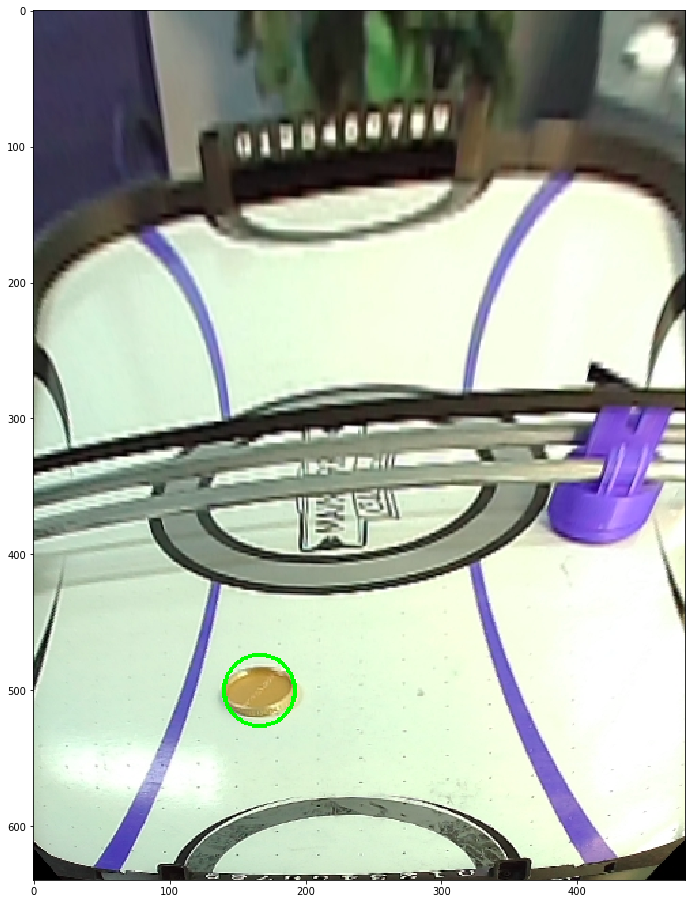

In [18]:
disp = puck_img.copy()
cv2.circle(disp, tuple([int_puck_center[1], int_puck_center[0]]), int_puck_radius, (0,255,0), 2)
show_img(disp)

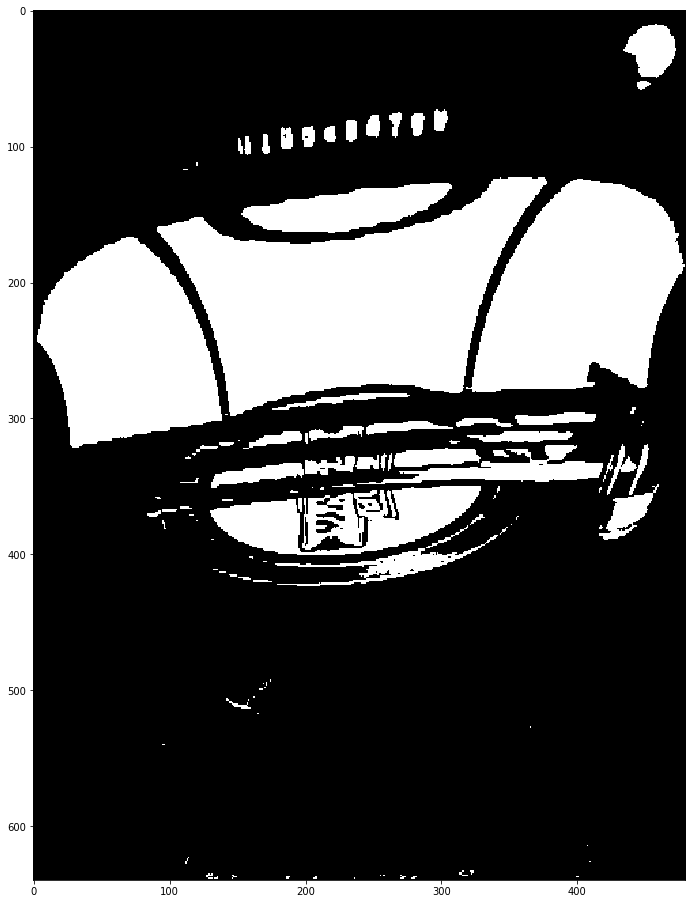

In [150]:
from skimage import segmentation, filters, img_as_ubyte

just_gray = cv2.cvtColor(puck_img, cv2.COLOR_BGR2GRAY)
mask = just_gray > filters.threshold_otsu(just_gray)
clean_border = segmentation.clear_border(mask)
show_img(clean_border)